# Road Vehicles Platooning using Multi-Agent Reinforcement Learning
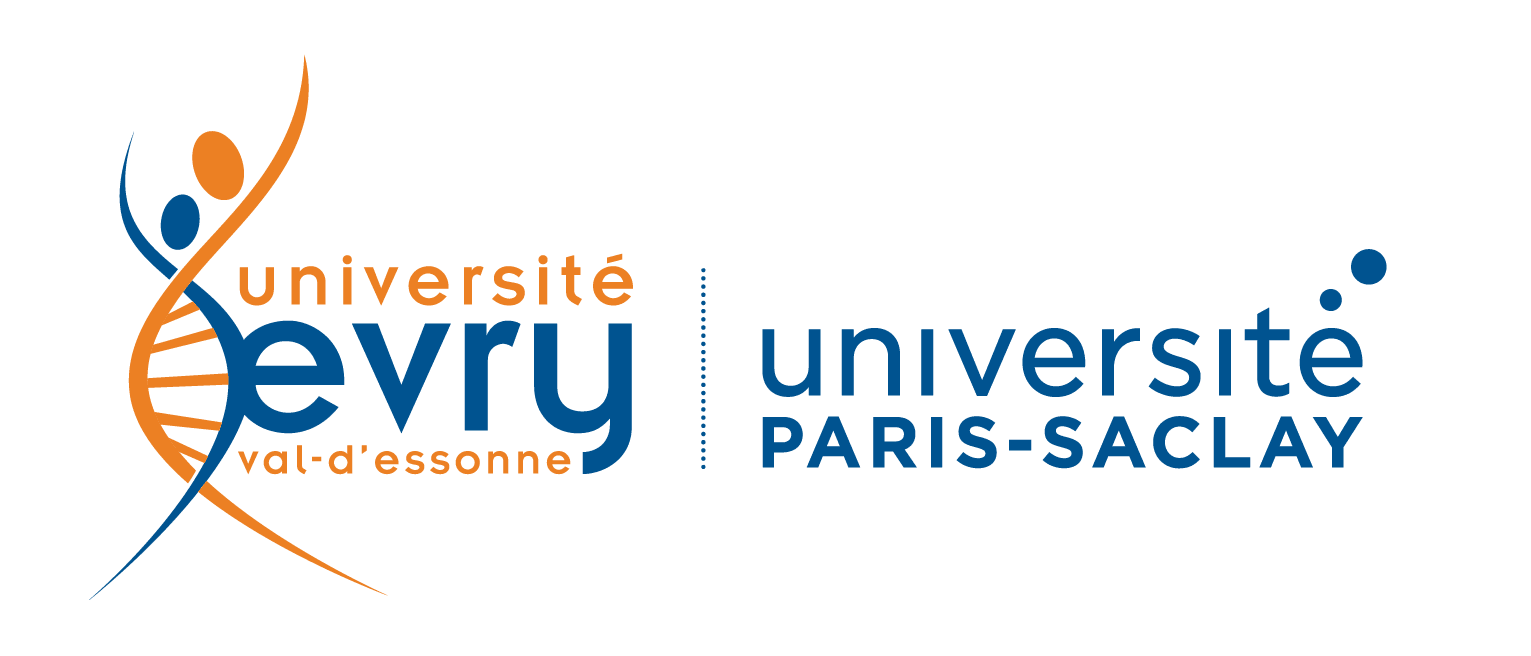
 **Prepared by: Charbel ABI HANA**

# Table of Contents


## Intro 

In this project, we aim to tackle the problem of vehicle platooning and traffic management with multiple vehicles on roads. We will tackle this problem using Reinforcement Learning technique called Deep-Q-Learning in a simulated environment called *highway-env* which utilized OpenAI GYM environment as a backbone.

## Reinforcement Learning

Reinforcement Learning is a Machine Learning discipline where it uses many well-established methods of supervised learning such as deep neural networks for function approximation, stochastic gradient descent and backpropagation to learn data representations.

### Agent, Environment, State, Reward
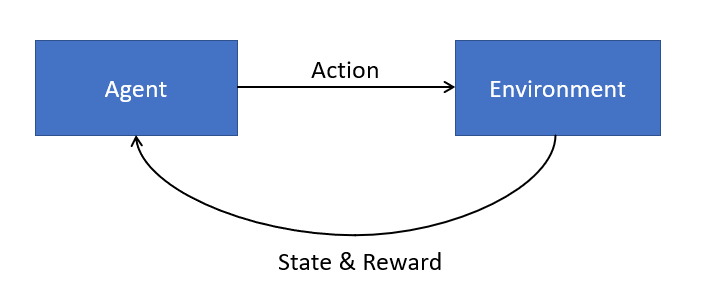

Reinforcement learning models learn from an environment. The environment has a set of rules and is usually assumed to be deterministic. A reinforcement learning model interacts with the environment through an agent. The agent has a state in the environment, and the agent can perform actions that change the state of the agent in the environment.

When the agent takes an action, the environment will receive this as an input and will output the resulting state and a reward (see diagram above).
In other machine learning problems we usually start by defining a loss function, then we look to optimize. In reinforcement learning, we cannot immediately do that. To help us formulate a loss, we can start by looking at the rewards given back by the environment.

### Value, Reward, Policy
An agent interacts with an environment through actions, these actions change the state of the environment. The goal of the model is to determine what actions will lead to the maximum reward.

To determine the best action, reinforcement learning works by estimating the value of actions. The value of an action indicates how good an action is. 

<div class="alert alert-block alert-warning">
<b>Value:</b> The value of an action is defined as the sum of the immediate reward received by taking an action plus the expected value of the resulting state multiplied by a scaling term. In other words, the value of an action is how good the next state will be after taking that action, plus the expected future reward from that new state.
</div>

Reinforcement learning models update their value function by interacting with the environment, choosing an action, looking at the new state, looking at the reward then updating.

Aside from the value function, the model needs to learn a policy.

<div class="alert alert-block alert-warning">
<b>Policy:</b> The policy of the algorithm is how it chooses what action to take based on the value of the current state.
</div>

Reinforcement learning algorithms want to evaluate states as best as possible (value function) to help them make decisions (policy) that lead to the maximum reward.

### Estimating the Value Function

Reinforcement learning is all about the value function (how good our state/actions are). The models learn sequentially by integrating with the environment for a number of episodes. Episodes can be thought of as epochs in reinforcement learning, and in the chess example they would indicate the number of complete games the agent trains for.

### Q-Learning/Deep-Q-Learning

#### Tabular Q-Learning
Q-learning is an off policy reinforcement learning algorithm that seeks to find the best action to take given the current state. It’s considered off-policy because the q-learning function learns from actions that are outside the current policy, like taking random actions, and therefore a policy isn’t needed. More specifically, q-learning seeks to learn a policy that maximizes the total reward.

The ‘q’ in q-learning stands for quality. Quality in this case represents how useful a given action is in gaining some future reward.

When q-learning is performed we create what’s called a q-table or matrix that follows the shape of `[state, action]` and we initialize our values to zero. We then update and store our q-values after an episode. This q-table becomes a reference table for our agent to select the best action based on the q-value.
An agent interacts with the environment in 1 of 2 ways. The first is to use the q-table as a reference and view all possible actions for a given state. The agent then selects the action based on the max value of those actions. This is known as exploiting since we use the information we have available to us to make a decision.

The second way to take action is to act randomly. This is called exploring. Instead of selecting actions based on the max future reward we select an action at random. Acting randomly is important because it allows the agent to explore and discover new states that otherwise may not be selected during the exploitation process. We can balance the exploration/exploitation by adjusting the discount factor shown in the formula below:
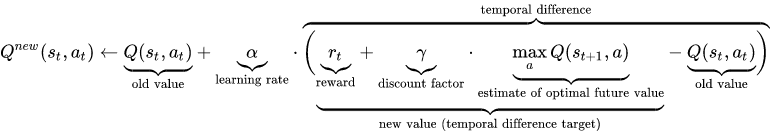

#### Deep-Q-Learning

The Q-learning method that we've reviewed above solves the issue with iteration over the full set of states in the environment, but still can struggle with situations when the count of the observable set of states is very large. As a solution to this problem, we can use a nonlinear representation that maps both state and action onto a value. In machine learning this is called a "regression problem." The concrete way to represent and train such a representation can vary, but, we will be using a deep neural network with *Conolutional* layers and *Dense* layers. We will be building on top of a DQN implementation developed by [PFRL](https://github.com/pfnet/pfrl).

## Multi-Agent Reinforcement Learning

Multi-agent reinforcement learning studies how multiple agents interact in a common environment. That is, when these agents interact with the environment and one another, can we observe them collaborate, coordinate, compete, or collectively learn to accomplish a particular task. It can be further broken down into three broad categories:

- Cooperative: All agents working towards a common goal

- Competitive: Agents competing with one another to accomplish a goal

- Some mix of the two
In addition, we can represent multi-agent problems in a centralized algorithm that communicates with the agents in the environment making all of their respective observations constantly available to the central algorithm. Another aproach, which has shown more promise, is to consider each agent as an independent agent and each agent learns based on the reward function which deviates the training to a shared objective.

In this project, we'll be developing our RL algorithm to perform the cooperative task by achieving successful transportation of a platoon of vehicles (2 vehicles or more) and traverse a highway at high speed and without collisions.

## OpenAI GYM

The Python library called Gym was developed and has been maintained by OpenAI (www.openai.com). The main goal of Gym is to provide a rich collection of environments for RL experiments using a unified interface. The central class in the library is an environment, which is called *Env*. It exposes several methods and fields that provide the required information about an environment's capabilities. From high level, every
environment provides us with these pieces of information and functionality:
- A set of actions that are allowed to be executed in an environment. Gym supports both discrete and continuous actions, as well as their combination. The shape and boundaries of the observations that an environment provides the agent with.
- A method called step to execute an action, which returns the current observation, reward, and indication that the episode is over.
- A method called reset to return the environment to its initial state and to obtain the first observation.

### Action Space
the actions that an agent can execute can be discrete, continuous, or a combination of both. Discrete actions are a fixed set of things that an agent could do, for example, directions in a grid like left, right, up, or down. Another example is a push button, which could be either pressed or released. Both states are mutually exclusive, because a main characteristic of a discrete action space is that only one action from the action space is possible. A continuous action has a value attached to it, for instance, a steering wheel, which can be turned at a specific angle, or an accelerator pedal, which can be pressed with different levels of force.

### Observation Space
Observations are pieces of information that an environment provides the agent with, on every timestamp, besides the reward. Observations can be as simple as a bunch of numbers or as complex as several multidimensional tensors containing color images from several cameras. An observation can even be discrete, much like action spaces. An example of such a discrete observation space could be a light bulb, which could be in two states: on or off, given to us as a Boolean value.

## Highway Environment

### Envrionment Overview
This environment is a minimalist python implementation of a highway simulation. There is a multitude of environments present in the package provided by the developers at https://github.com/eleurent/highway-env. We can visualize two of these environments below. In addition, extracted data on the environment is shown the developers documentation [here](https://highway-env.readthedocs.io/en/latest/quickstart.html).

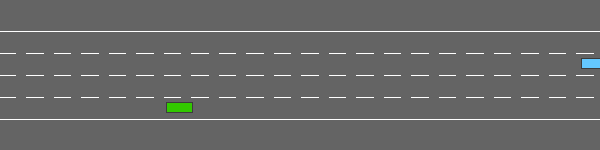

<div class="alert alert-block alert-success">
<b>Highway-v0-environment:</b> Multilane highway environment where ego/agent vehicles navigate at high speeds while avoiding collisions with neighbouring vehicles.
</div>

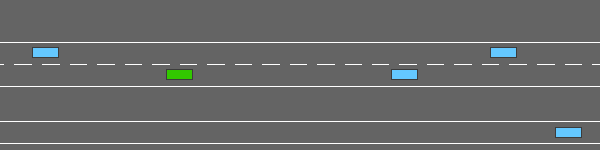
<div class="alert alert-block alert-success">
<b>Merge-v0-environment:</b> ego/agent vehicles approach a merging lane as they are travelling on a highway. Merging lanes have other vehicles coming out to merge on highway and agents should avoid those cars. 
</div>

### Action Space

The actions shown below represent the discrete action space of any RL agent. The availability of these actions depends on the positioning of the agent in the environment (lane changes at the edges of the roads, or accelerating/decelrating beyond the maximum/minimum velocity), and the list of available actions can be accessed with `get_available_actions()` method. Taking an unavailable action is equivalent to taking the `IDLE` action.

<div class="alert alert-block alert-info">
<b>DiscreteMetaAction:</b> <br>
    &emsp;<em>ACTIONS_ALL</em> = <br> 
    &emsp;{ <br>
        &emsp;&emsp;0: 'LANE_LEFT',<br>
        &emsp;&emsp;1: 'IDLE',<br>
        &emsp;&emsp;2: 'LANE_RIGHT',<br>
        &emsp;&emsp;3: 'FASTER',<br>
        &emsp;&emsp;4: 'SLOWER'<br>
    &emsp;}<br>
</div>


### Observation Space

We'll be using the `KinematicObservation` which essentially is $V \times F$ array where $V$ represents a list of nearby vehicles and $F$ represents the feature being the $x-y$ positions and velocities:
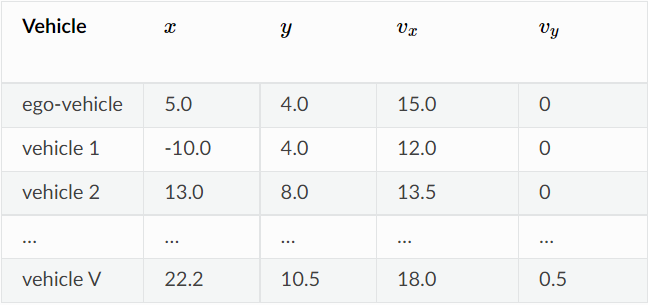

### Reward Function
The general focus is on two features: a vehicle should progress quickly on the road and should avoid collisions.

Thus, the reward function is often composed of a velocity term and a collision term:
$$R(s,a) = a\frac{v - v_\min}{v_\max - v_\min} - b\,\text{collision}$$
where $v$, $v_{min}$, $v_{max}$ are the current, minimum and maximum speed of the ego-vehicle respectively, and $a, b$ are two coefficients.

### IDQN - Independent Agents - Development

#### Imports

In [1]:
import gym
import highway_env
import pfrl
import numpy as np
import torch
import torch.nn as nn

from typing import Tuple

from highway_env import utils

from pfrl import explorers, replay_buffers
from pfrl.explorer import Explorer
from pfrl.agents import DQN
from pfrl.q_functions import DiscreteActionValueHead
from pfrl.utils.contexts import evaluating

# Visualization utils
import tensorboard

from tensorboardX import SummaryWriter

from tqdm.notebook import trange

In [ ]:
# works on google colab
#import sys

#sys.path.insert(0, "highway-env/scripts/")
#from utils import show_videos

#### Tensorboard for Visualization Initialization

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=runs

In [ ]:
# Create summary writer for tensorboard
writer: SummaryWriter = SummaryWriter(flush_secs=1)

#### Environment Init

In [2]:
env = gym.make('highway-v0')
env.seed(0)

[0]

#### Some Environment Visuals

In [ ]:
env.configure({"controlled_vehicles": 2})  # Two controlled vehicles
env.configure({"vehicles_count": 1})  # A single other vehicle, for the sake of visualisation
env.reset()

from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(env.render(mode="rgb_array"))
plt.title("Controlled vehicles are in green")
plt.show()

env.configure({
  "action": {
    "type": "MultiAgentAction",
    "action_config": {
      "type": "DiscreteMetaAction",
    }
  }
})
env.reset()

_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.imshow(env.render(mode="rgb_array"))
ax1.set_title("Initial state")

# Make the first vehicle change to the left lane, and the second one to the right
action_1, action_2 = 0, 2  # See highway_env.envs.common.action.DiscreteMetaAction.ACTIONS_ALL
env.step((action_1,action_2))

ax2.imshow(env.render(mode="rgb_array"))
ax2.set_title("After sending actions to each vehicle")
plt.show()

#### Developing the Agent

In [ ]:
class Agent(object):
    def __init__(self):
        if torch.cuda.is_available():
            device = "cuda:0"
        else:
            device = "cpu"
        self.device = torch.device(device)

    def act(self, observation):
        raise NotImplementedError

    def observe(self, observation, reward, done, info):
        raise NotImplementedError


class IndependentAgent(Agent):
    def __init__(self, config, obs_act):
        super().__init__()
        self.config = config
        self.agents = dict()

    def act(self, observation):
        acts = dict()
        for agent_id in observation.keys():
            acts[agent_id] = self.agents[agent_id].act(observation[agent_id])
        return acts

    def observe(self, observation, reward, done, info):
        for agent_id in observation.keys():
            self.agents[agent_id].observe(observation[agent_id], reward[agent_id], done, info)
            if done:
                if info['eps'] % 100 == 0:
                    self.agents[agent_id].save(self.config['log_dir']+'agent_'+agent_id)

In [ ]:
class DQNAgent(Agent):
    def __init__(self, config, act_space, model):
        super().__init__()

        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters())
        replay_buffer = replay_buffers.ReplayBuffer(10000)


        explorer = explorers.LinearDecayEpsilonGreedy(
            config['EPS_START'],
            config['EPS_END'],
            config['steps'],
            lambda: np.random.randint(act_space),
        )

        self.agent = DQN(self.model, self.optimizer, replay_buffer, config['GAMMA'], explorer,
                         gpu=self.device.index,
                         minibatch_size=config['BATCH_SIZE'], replay_start_size=config['BATCH_SIZE'],
                         phi=lambda x: np.asarray(x, dtype=np.float32),
                         target_update_interval=config['TARGET_UPDATE'])

    def act(self, observation):
        return self.agent.act(observation)

    def observe(self, observation, reward, done, info):
        self.agent.observe(observation, reward, done, False)

    def save(self, path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, path+'.pt')

In [ ]:
class IDQN(IndependentAgent):
    def __init__(self, config, obs_act):
        super().__init__(config, obs_act)
        for key in obs_act:
            obs_space = obs_act[key][0]
            act_space = obs_act[key][1]

            def conv2d_size_out(size, kernel_size=2, stride=1):
                return (size - (kernel_size - 1) - 1) // stride + 1

            h = conv2d_size_out(obs_space[1])
            w = conv2d_size_out(obs_space[2])

            model = nn.Sequential(
                nn.Conv2d(obs_space[0], 64, kernel_size=(2, 2)),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(h * w * 64, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, act_space),
                DiscreteActionValueHead()
            )

            self.agents[key] = DQNAgent(config, act_space, model)

In [ ]:
def develop_observations(env_obs: Tuple[np.ndarray]):
    return {f"vehicle_{i}":obs[np.newaxis] for i, obs in enumerate(env_obs)}

In [ ]:
config = {'BATCH_SIZE': 32,
'GAMMA': 0.99,
'EPS_START': 1.0,
'EPS_END': 0.0,
'TARGET_UPDATE': 500,
'steps': 1.0,
'log_dir': 'idqn_logs/'}

In [ ]:
controlled_vehicles = 3
actions = 5
observation_space_batched = (1, 5, 5)
obs_act = {f"vehicle_{i}":(observation_space_batched, actions) for i in range(controlled_vehicles)}
obs_act

In [ ]:
alg = IDQN(config= config, obs_act= obs_act)

#### Environment Config

In [ ]:
# Multi-agent environment configuration
env.configure({
  "controlled_vehicles": controlled_vehicles,
  "ego_spacing": 1,
  "observation": {
    "type": "MultiAgentObservation",
    "observation_config": {
      "type": "Kinematics",
    }
  },
  "action": {
    "type": "MultiAgentAction",
    "action_config": {
      "type": "DiscreteMetaAction",
    }
  }
})

In [3]:
from matplotlib import pyplot as plt

In [61]:
env = gym.make('highway-v0')

In [62]:
env.configure({
  "controlled_vehicles": 3,
  "ego_spacing": 1,
  "observation": {
    "type": "MultiAgentObservation",
    "observation_config": {
      "type": "Kinematics",
      "vehicles_count": 6,
      "features": ["presence", "x", "y", "vx", "vy", "cos_h"],
      "features_range": {
          "x": [-600, 600],
          "y": [-100, 100],
          "vx": [-30, 30],
          "vy": [-30, 30]
      },
      "absolute": False,
      "normalize": False,
      "order": "sorted"
    }
  },
  "action": {
    "type": "MultiAgentAction",
    "action_config": {
      "type": "DiscreteMetaAction",
    }
  },
    "vehicles_count": 5,
    "vehicles_density": 2,
    #"show_trajectories": True,
    "screen_width": 1280,
    "screen_height": 720
})

In [63]:
env.env.config

{'observation': {'type': 'MultiAgentObservation',
  'observation_config': {'type': 'Kinematics',
   'vehicles_count': 6,
   'features': ['presence', 'x', 'y', 'vx', 'vy', 'cos_h'],
   'features_range': {'x': [-600, 600],
    'y': [-100, 100],
    'vx': [-30, 30],
    'vy': [-30, 30]},
   'absolute': False,
   'normalize': False,
   'order': 'sorted'}},
 'action': {'type': 'MultiAgentAction',
  'action_config': {'type': 'DiscreteMetaAction'}},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 1280,
 'screen_height': 720,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 5,
 'controlled_vehicles': 3,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 1,
 'vehicles_density': 2,
 'collision_reward': -1,
 'right_lane_rew

In [64]:
class RewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.env = env
    
    def reward(self, reward):
        # Placeholder actions, values won't be used
        actions = range(5)
        ego_vehicles = self.env.controlled_vehicles
        reward_per_vehicle = {}
        for action, vehicle in zip(actions, ego_vehicles):
            reward_per_vehicle[vehicle] = self._reward_per_vehicle(action, vehicle)
            
        return reward_per_vehicle
    
    def _reward_per_vehicle(self, action, vehicle: highway_env.vehicle.controller.MDPVehicle):
        """
        The reward is defined to foster driving at high speed, on the rightmost lanes, and to avoid collisions.
        :param action: the last action performed
        :return: the corresponding reward
        """
        neighbours = self.env.road.network.all_side_lanes(vehicle.lane_index)
        lane = vehicle.target_lane_index[2] if isinstance(vehicle, highway_env.vehicle.controller.ControlledVehicle) \
            else vehicle.lane_index[2]
        # Use forward speed rather than speed, see https://github.com/eleurent/highway-env/issues/268
        forward_speed = vehicle.speed * np.cos(vehicle.heading)
        scaled_speed = utils.lmap(forward_speed, self.env.config["reward_speed_range"], [0, 1])
        reward = \
            + self.env.config["collision_reward"] * vehicle.crashed \
            + self.env.config["right_lane_reward"] * lane / max(len(neighbours) - 1, 1) \
            + self.env.config["high_speed_reward"] * np.clip(scaled_speed, 0, 1)
        reward = utils.lmap(reward,
                          [self.env.config["collision_reward"],
                           self.env.config["high_speed_reward"] + self.env.config["right_lane_reward"]],
                          [0, 1])
        reward = 0 if not vehicle.on_road else reward
        return reward

In [65]:
env = RewardWrapper(env)

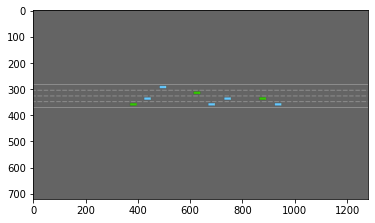

In [66]:
env.reset()
plt.imshow(env.render(mode= "rgb_array"))

[[  1.        113.2717     12.         25.          0.          1.       ]
 [  1.          6.65883    -4.         -4.1617417   0.          1.       ]
 [  1.         17.063965  -12.         -3.5494292   0.          1.       ]
 [  1.         44.21145    -8.          0.          0.          1.       ]
 [  1.         49.8673      0.         -5.176112    0.          1.       ]
 [  1.         60.932625   -4.         -5.7359753   0.          1.       ]]
Env Reward is:  {MDPVehicle #504: [113.27169692  12.        ]: 0.8666666666666667, MDPVehicle #632: [157.48314549   4.        ]: 0.8222222222222223, MDPVehicle #16: [203.23607528   8.        ]: 0.8444444444444444}


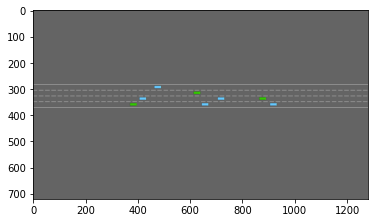

In [67]:
next_obs, _, done, info = env.step((1, 1, 1))
plt.imshow(env.render(mode= "rgb_array"))
print(next_obs[0])
print("Env Reward is: ", _)

In [22]:
wrapped_env = RewardWrapper(env)

In [29]:
reward = wrapped_env.reward((1, 1, 1))
print("Custom Reward is: ", reward)

(1, 1, 1)
Custom Reward is:  {MDPVehicle #768: [115.5300473   8.       ]: 0.8444444444444444, MDPVehicle #704: [157.7190851   0.       ]: 0.7999999999999999, MDPVehicle #408: [201.49609947   4.        ]: 0.8222222222222223}


In [ ]:
env.reward()

In [ ]:
done

In [ ]:
from IPython import display

def show_state(env, is_ipython, step):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title(f"Step: {step}")
    
    plt.pause(0.001)  # pause for plots to update

    if is_ipython:
        display.clear_output(wait=True)

#### Training Loop

In [ ]:
# 100 training episodes
for episode in trange(100, desc= "Training Episodes"):
    obs = env.reset()
    developed_obs = develop_observations(obs)
    done = False
    while not done:
        # shows gif of each episode in jupyter notebook
        show_state(env, True, episode)
        # Dispatch the observations to the model to get the tuple of actions
        action = alg.act(developed_obs)
        full_action = (action_disc for _, action_disc in action.items())
        # Execute the actions
        next_obs_full = []
        rewards = {}

        infos = {"speed": [], "crashed": [], "action": [], "cost": [], "eps": 0}
        for i, action in enumerate(full_action):
            action_list = [1 for _ in range(controlled_vehicles)]
            action_list[i] = action
            next_obs, reward, done, info = env.step(tuple(action_list))
            rewards[f"vehicle_{i}"] = reward
            infos["speed"].append(info["speed"])
            infos["crashed"].append(info["crashed"])
            infos["action"].append(info["action"][0])
            infos["cost"].append(info["cost"])
        infos["eps"] += 1
        next_obs_full.append(next_obs[i])
        next_obs_full = develop_observations(tuple(next_obs_full))
        
        writer.add_scalars(main_tag= "rewards per vehicle", tag_scalar_dict= rewards, global_step= episode)
        # Update the model with the transitions observed by each agent
        alg.observe(next_obs_full, rewards, done, infos)
writer.close()